# Challenge: Topic extraction on new data

Take the well-known [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset and use each of the methods on it.  Our goal here is to determine which method, if any, best reproduces the topics represented by the newsgroups.  

In [4]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [15]:
file = 'C:/Users/Amichai/Documents/Thinkful\Module 37 - Advanced NLP/20news-19997.tar.gz'
import tarfile
tf = tarfile.open(file)
tf.extractall()

In [21]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups()


In [72]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Processing the data.
news_files=[]
for file_text in newsgroups.data:
    #removing the double-dash from all words
    file_text=[re.sub(r'--','',word) for word in file_text.split()]
    #Forming each paragraph into a string and adding it to the list of strings.
    news_files.append(' '.join(file_text))

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
news_tfidf=vectorizer.fit_transform(news_files)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=len(newsgroups.target_names)

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


In [62]:
# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_lsa = lsa.fit_transform(news_tfidf)

components_lsa = word_topic(news_tfidf, news_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)      

In [76]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

news_lda = lda.fit_transform(news_tfidf) 

components_lda = word_topic(news_tfidf, news_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


In [77]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
news_nmf = nmf.fit_transform(news_tfidf) 

components_nmf = word_topic(news_tfidf, news_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [116]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic], '\n')

Topic 0:
                  LSA                LDA          NNMF
0          edu 222.72           edu 5.34      car 2.45
0           com 154.2           com 3.46      edu 1.74
0        subject 95.6       subject 2.39      com 1.72
0         lines 94.84         lines 2.36     bike 1.24
0  organization 93.79  organization 2.34     like 1.08
0        writes 91.16    university 2.11     just 1.05
0       article 88.95       posting 1.98      don 0.99
0    university 84.13          host 1.93     good 0.99
0           don 79.35          nntp 1.91  article 0.97
0          like 78.25       article 1.88   writes 0.96 

Topic 1:
                LSA                LDA             NNMF
1         god 47.09           edu 4.16         god 8.42
1      people 24.44           com 2.99       jesus 3.67
1       jesus 22.34       subject 1.92       bible 2.37
1       bible 14.74         lines 1.91         edu 2.31
1  christians 14.09  organization 1.87       people 2.3
1   christian 14.09    university 1.79 

The extracted top words for each method and topic are being skewed by an overabundance of email addresses, websites, and certain terms like 'university', 'subject', and 'organization'. If we remove that information and re-run the various models, we can get more accurate key term extraction.

In [206]:
# Processing the data.
news_files=[]
for file_text in newsgroups.data:
    #Remove non-useful/extraneous info:
    file_text = ' '.join([sent for sent in file_text.split('\n') if ('From: ' not in sent and 'To: ' not in sent and 'Re: ' not in sent and 'Host:' not in sent and 'Sender:' not in sent and 'Lines:' not in sent and 'Organization:' not in sent)])
    #Remove common words and embedded email addresses
    file_text = ' '.join([word for word in file_text.split() if (word not in ['Subject:','Distribution:'] and '@' not in word)])
    #removing the double-dash from all words
    file_text = ' '.join([re.sub(r'--','',word) for word in file_text.split()])
    #Remove extraneous formatting from all words
    file_text = ' '.join([re.sub(r'==','',word) for word in file_text.split()])
    file_text = ' '.join([re.sub(r'__','',word) for word in file_text.split()])
    #Forming each paragraph into a string and adding it to the list of strings.
    news_files.append(file_text)

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
news_tfidf=vectorizer.fit_transform(news_files)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=len(newsgroups.target_names)


In [207]:
# LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_lsa = lsa.fit_transform(news_tfidf)

components_lsa = word_topic(news_tfidf, news_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)      

In [208]:
# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

news_lda = lda.fit_transform(news_tfidf) 

components_lda = word_topic(news_tfidf, news_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


In [209]:
# NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
news_nmf = nmf.fit_transform(news_tfidf) 

components_nmf = word_topic(news_tfidf, news_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [210]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic], '\n')

Topic 0:
              LSA           LDA          NNMF
0   writes 120.49  article 3.35      don 3.08
0  article 117.93   writes 3.27    people 3.0
0       don 96.22      like 2.5     just 2.66
0      just 93.54      don 2.37    think 2.44
0      like 92.37   people 2.25     like 2.43
0    people 90.47     know 2.22     know 2.22
0      know 87.33     just 2.18   writes 2.05
0     think 78.56     think 2.1  article 1.88
0      does 70.73     does 1.84     good 1.74
0      good 67.16     good 1.75     time 1.66 

Topic 1:
              LSA           LDA          NNMF
1   windows 39.39  article 2.76  windows 4.46
1     thanks 29.1   writes 2.48      dos 1.99
1      card 23.89       ax 2.38     file 1.77
1     drive 21.91      like 2.0    files 1.32
1        dos 19.6     just 1.91       ms 1.04
1      file 18.35      know 1.8  program 0.86
1        pc 18.08     does 1.78      use 0.85
1      mail 18.03   thanks 1.66      run 0.67
1       use 17.81       don 1.6   thanks 0.66
1  software 17

In [211]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

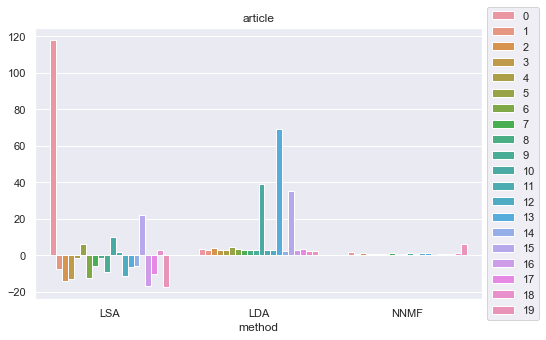

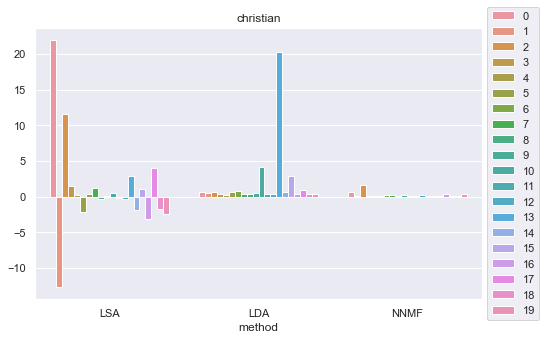

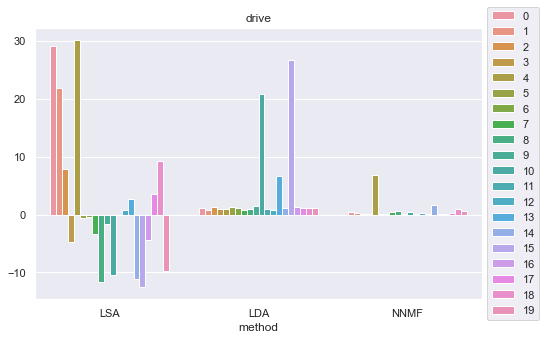

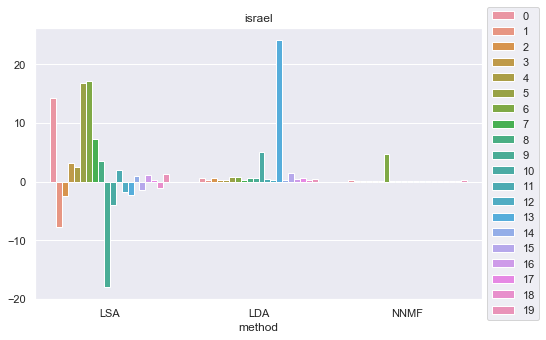

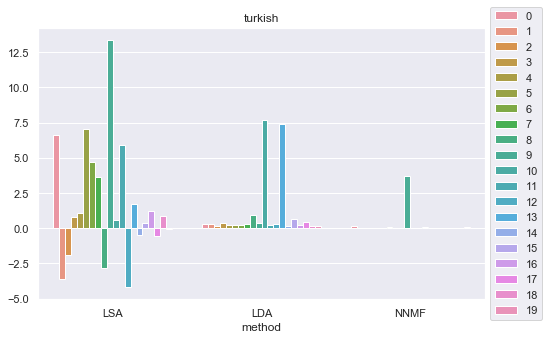

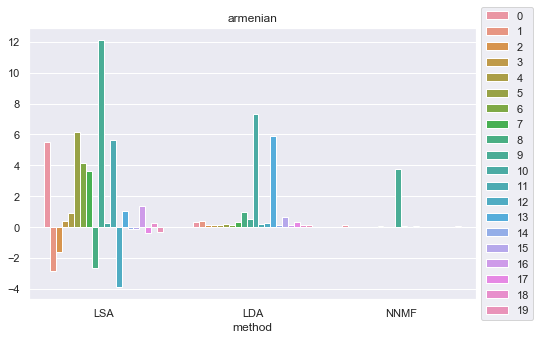

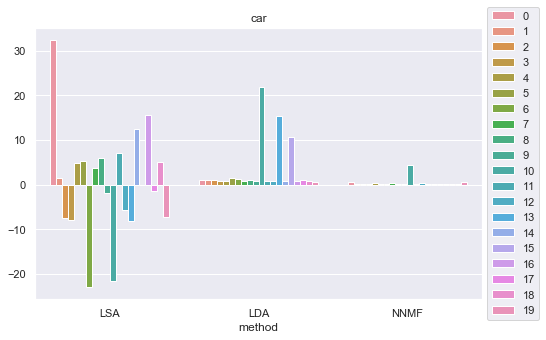

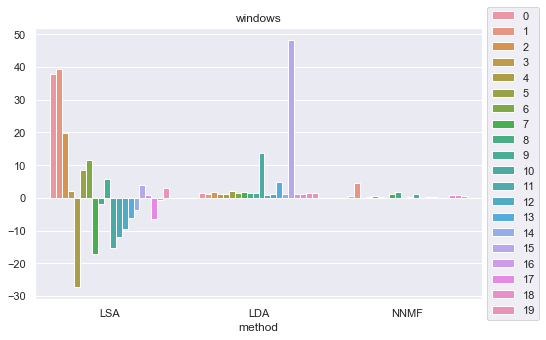

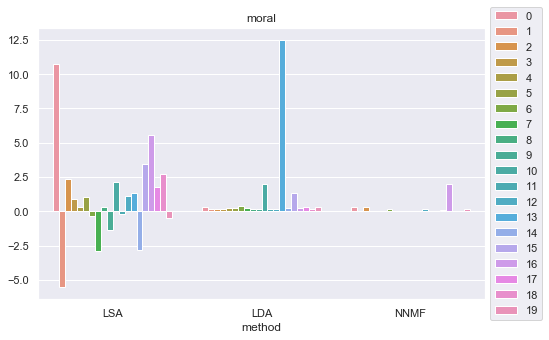

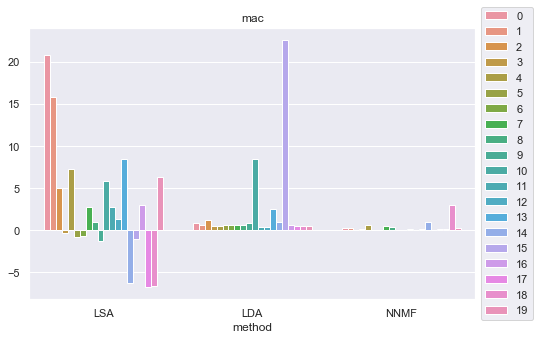

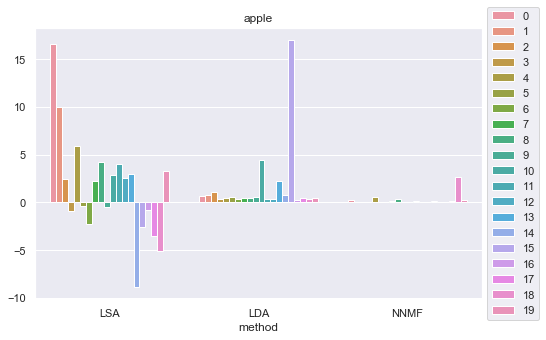

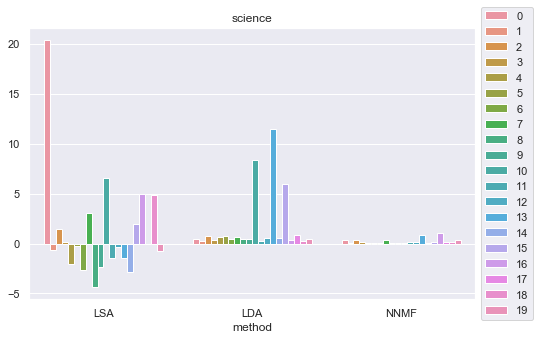

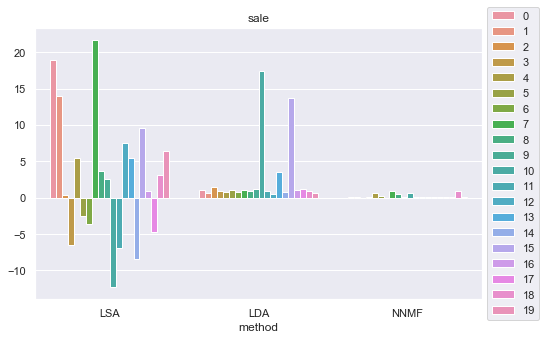

In [217]:
# The words to look at.
targetwords=['article', 'christian', 'drive', 'israel', 'turkish', 'armenian', 'car', 'windows', 'moral', 'mac', 'apple', 'science', 'sale']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], ntopics, axis=0)
wordloadings['loading']=list(range(ntopics))*3

sns.set(style="darkgrid")

for word in targetwords:
    fig = plt.figure(figsize=(10,5))
    ax = sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()